## Preliminares

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

from qiskit import Aer, QuantumCircuit, transpile
from qiskit.opflow import Z, I
from qiskit.utils import  algorithm_globals
from qiskit.algorithms.optimizers import SPSA

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_qsphere

from IPython.display import clear_output

from sklearn.model_selection import train_test_split,cross_val_score

algorithm_globals.random_seed = 42
hamiltonian = Z ^ I ^ I ^ I ^ I ^ I ^ I


from Aux_Data import plot_predicted, plot_area, plot_bloch_sphere, plot_sampled_features
from QWNN import  quantum_weightless_neuron_ry, quantum_weightless_nn
from quantum_encoding import angle_encoding
from Aux_QuantumML import get_opflow_qnn,apply_circuit, get_bloch_coordinates, get_statevector



## Base de dados selecionada:

In [17]:
class_a = 1
class_b = 2
# Loading some example data
iris = datasets.load_iris()
X_all = iris.data[:,:]
Y_all = iris.target
X_vec = [np.array(X_all[Y_all == 0]), np.array(X_all[Y_all == 1]), np.array(X_all[Y_all == 2])]
Y_vec = [np.array(Y_all[Y_all == 0]),np.array(Y_all[Y_all == 1]), np.array(Y_all[Y_all == 2])]
X = np.concatenate((X_vec[class_a], X_vec[class_b]), axis=0)
Y = np.concatenate((Y_vec[class_a], Y_vec[class_b]), axis=0)

# Randomly shuffle data and labels 
rnd = np.random.RandomState(42)
idx = rnd.permutation(len(Y))
X, Y = X[idx], Y[idx]

# Scale to the range (0, +1)
y01 = (Y - min(Y))
y01 = y01 // max(y01)
y = 2 * y01 -1

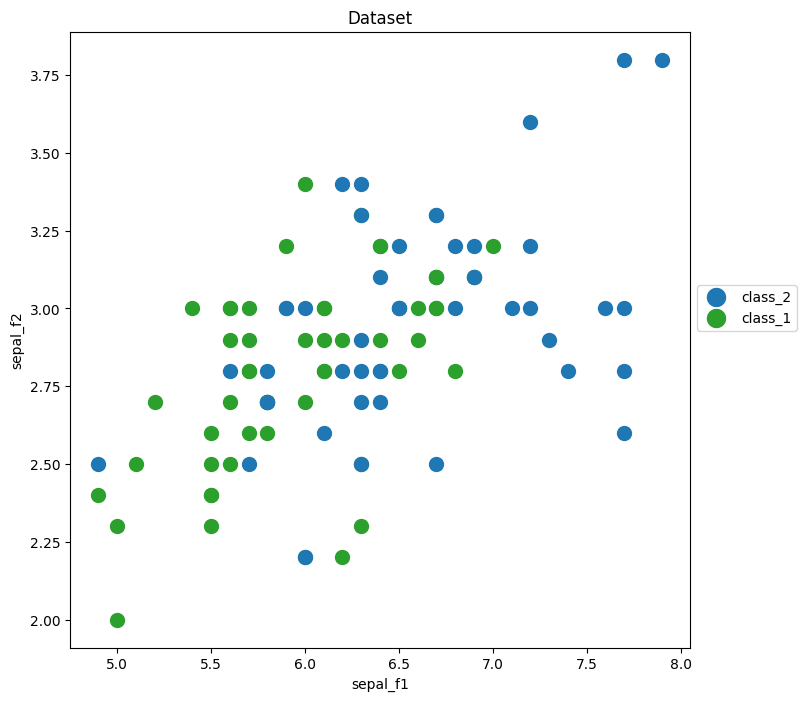

In [19]:
plot_sampled_features(X[:, [0,1]], y, axis_x_name='sepal_f1', axis_y_name='sepal_f2', class_name_minus="class_1", class_name_plus="class_2")

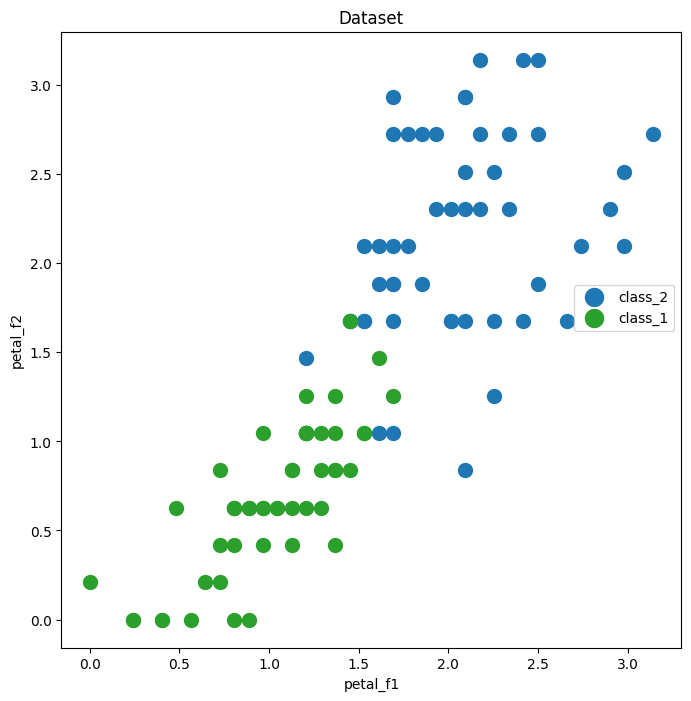

In [21]:
plot_sampled_features(X[:, [2,3]], y, axis_x_name='petal_f1', axis_y_name='petal_f2', class_name_minus="class_1", class_name_plus="class_2")

In [22]:
normalization = np.pi
# Normalize X
minmax_scale = MinMaxScaler((0, normalization)).fit(X)
X = minmax_scale.transform(X)

## Circuito

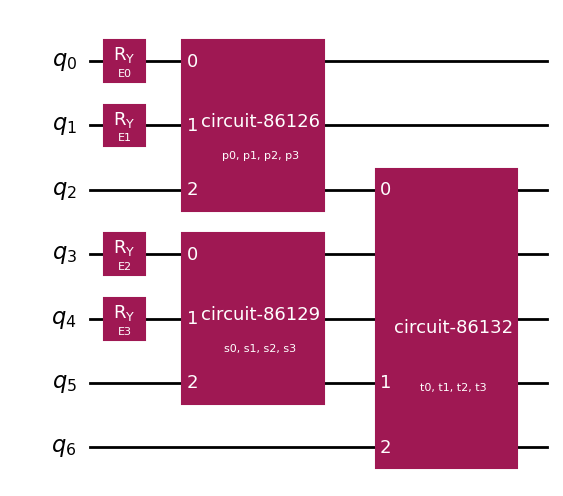

In [23]:
test = QuantumCircuit(7)
feature_map = angle_encoding(4)
test.append(feature_map, [0,1,3,4])
ansatz= quantum_weightless_nn()
test.append(ansatz, [0,1,2,3,4,5,6])
test.decompose().draw('mpl', style='iqx')

In [24]:
# callback function that draws a live plot when the .fit() method is called
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.figsize"] = (6, 4)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


In [9]:
qnn = get_opflow_qnn(test, feature_map, ansatz, hamiltonian)

## Treinamento

In [30]:
score_list = []
best_score = 0
best_clf = NeuralNetworkClassifier(qnn, optimizer = SPSA())
for i in range(5):
    qnn = get_opflow_qnn(test, feature_map, ansatz, hamiltonian)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=algorithm_globals.random_seed, stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, stratify=y)
    print("Iteration ", i)
    clf = NeuralNetworkClassifier(qnn, optimizer = SPSA())
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    score_list.append(score)
    if(score>best_score):
        best_score = score
        best_clf = clf
print("Mean: ", np.mean(score_list))
print("Std: ", np.std(score_list))
print(best_score)
print(best_clf._fit_result.x)

Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Mean:  0.9333333333333333
Std:  0.02267671143499361
0.9696969696969697
[ 0.70406047  0.26252347  1.34307781  0.33642071 -1.89501666  1.67389257
  0.79010742  0.24193852  1.00470872  0.10950177 -0.66866132  2.287781  ]


In [31]:
score_list

[0.9090909090909091,
 0.9393939393939394,
 0.9090909090909091,
 0.9393939393939394,
 0.9696969696969697]

Wrong predicted: 9


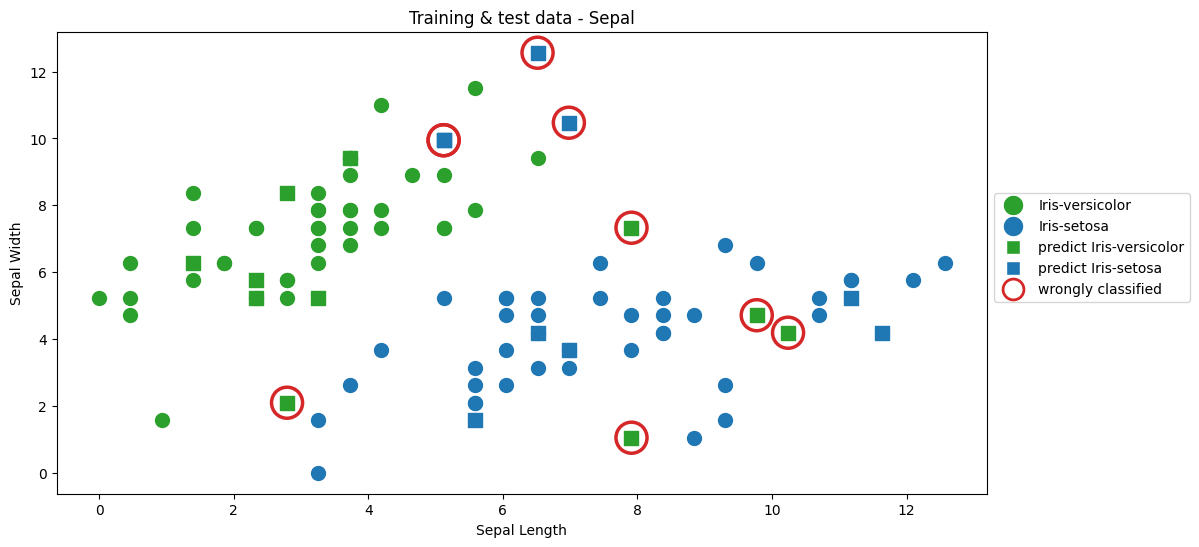

In [38]:
predicted = best_clf.predict(X_test)  
plot_predicted(1,2,X_train, y_train, X_test, y_test, predicted)

In [48]:
best_clf.save("neuron_spsa_4pi.model")

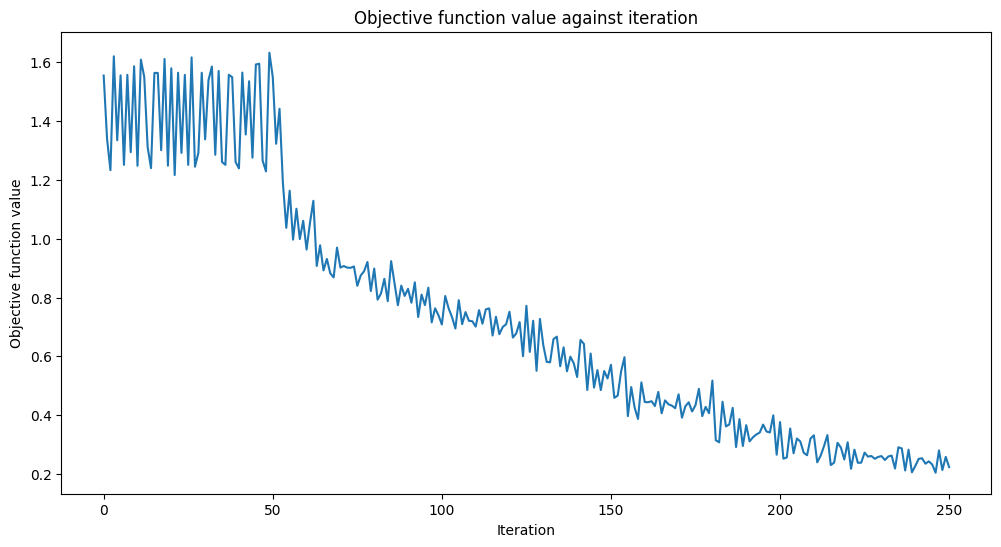

1.0

In [27]:
qnn = get_opflow_qnn(test, feature_map, ansatz, hamiltonian)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, stratify=y)
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer = SPSA(), callback=callback_graph)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X_test, y_test)

### Salvando o modelo

In [15]:
opflow_classifier.save("models/network_spsa_pi.model")

## Plotando os valores previstos

Wrong predicted: 0


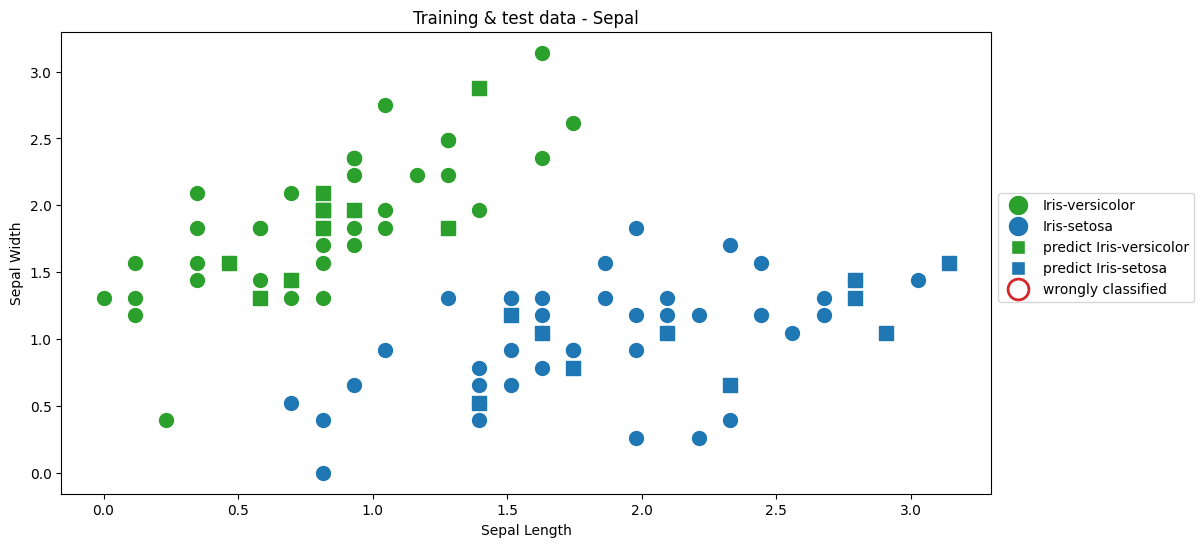

In [21]:
predicted = opflow_classifier.predict(X_test)  
plot_predicted(1,2,X_train, y_train, X_test, y_test, predicted)

Tentando ter ideia das regiões de decisão

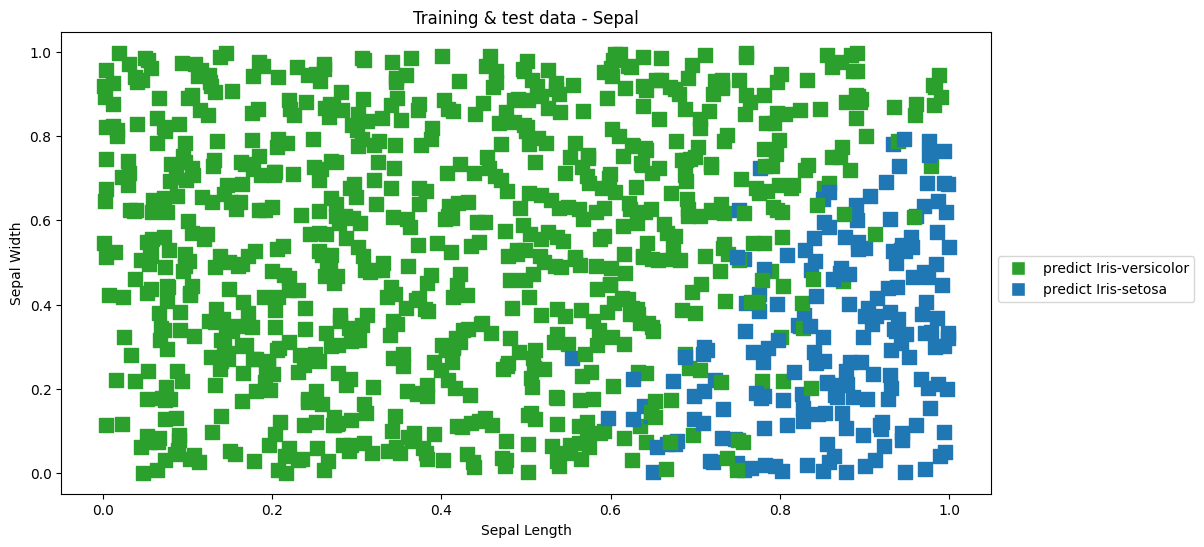

In [22]:
test2_col1 = np.random.uniform(low=0, high=1.0, size=(1000,))
test2_col2 = np.random.uniform(low=0, high=1.0, size=(1000,))
test2= np.vstack((test2_col2, test2_col1)).T

predicted = opflow_classifier.predict(test2)
plot_area(1,2, test2, predicted)

## Carregando modelo

In [16]:
#Para 4pi, utilizar 4pi-0.001
#normalization = 4*np.pi-0.001
normalization = np.pi
# Loading some example data
iris = datasets.load_iris()
X_all = iris.data[:, [0,1]]
Y_all = iris.target
X = np.array(X_all[:100])
Y = np.array(Y_all[:100])

# Randomly shuffle data and labels 
rnd = np.random.RandomState(42)
idx = rnd.permutation(len(Y))
X, Y = X[idx], Y[idx]

# Scale to the range (0, +1)
y01 = (Y - min(Y))
y01 = y01 // max(y01)

# Scale to the range (-1, +1)
minmax_scale = MinMaxScaler((0, normalization)).fit(X)
X = minmax_scale.transform(X)
y = 2 * y01 -1


In [19]:
opflow_classifier = NeuralNetworkClassifier.load("models/network_spsa_pi.model")
qnn = opflow_classifier.neural_network
theta = opflow_classifier._fit_result.x
theta

array([ 5.11977257e-05,  1.93023263e+00, -1.94686666e-01,  1.29994803e+00,
       -2.34548605e+00,  1.82394371e+00,  5.37665902e-01, -1.42076643e-01,
        9.58300695e-01,  2.67388893e-01,  2.69870370e+00,  1.85826191e+00])

## Plotando na Esfera de Bloch

Para esse caso aqui, ainda não faz sentido usar isso

### Explorando os pontos fixos

Como eles são aplicados no circuito (Porta Ry aplica rotação em theta/2)

In [7]:
print("Sen(theta/2): ", np.sin(theta/2))
print("Cos(theta/2): ",np.cos(theta/2))

Sen(theta/2):  [ 0.14122371  0.94178047  0.53647924 -0.59631076]
Cos(theta/2):  [0.98997771 0.33622842 0.84391352 0.80275369]


State Vector e Vetor de Bloch

In [8]:
print(get_statevector([0,0], theta))
print(get_statevector([0,np.pi], theta))
print(get_statevector([np.pi,0], theta))
print(get_statevector([np.pi,np.pi], theta))


Statevector([ 0.99 -0.j, -0.   -0.j, -0.   -0.j, -0.   +0.j,  0.141-0.j,
             -0.   -0.j, -0.   -0.j,  0.   -0.j],
            dims=(2, 2, 2))
Statevector([ 0.   +0.j,  0.   +0.j,  0.336-0.j, -0.   -0.j,  0.   +0.j,
              0.   +0.j,  0.942-0.j,  0.   +0.j],
            dims=(2, 2, 2))
Statevector([ 0.   +0.j,  0.844-0.j,  0.   +0.j, -0.   -0.j,  0.   +0.j,
              0.536-0.j,  0.   +0.j,  0.   +0.j],
            dims=(2, 2, 2))
Statevector([ 0.   +0.j,  0.   +0.j,  0.   +0.j,  0.803+0.j,  0.   +0.j,
              0.   +0.j,  0.   +0.j, -0.596+0.j],
            dims=(2, 2, 2))


In [9]:
print(get_bloch_coordinates([0,0], theta))
print(get_bloch_coordinates([0,np.pi], theta))
print(get_bloch_coordinates([np.pi,0], theta))
print(get_bloch_coordinates([np.pi,np.pi], theta))

[(0.27918+0j), (0.9601999999999999+0j)]
[(0.633024+0j), (-0.774208+0j)]
[(0.904768+0j), (0.42467199999999994+0j)]
[(-0.957176+0j), (0.28961800000000015+0j)]


### Plotando a esfera

C:\Users\thiag\AppData\Local\Temp\ipykernel_7524\2321318426.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  a[i] = get_bloch_coordinates(x= X[i], theta=theta)
C:\Users\thiag\AppData\Local\Temp\ipykernel_7524\2321318426.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  a_base[i] = get_bloch_coordinates(x= fix_P[i], theta=theta)


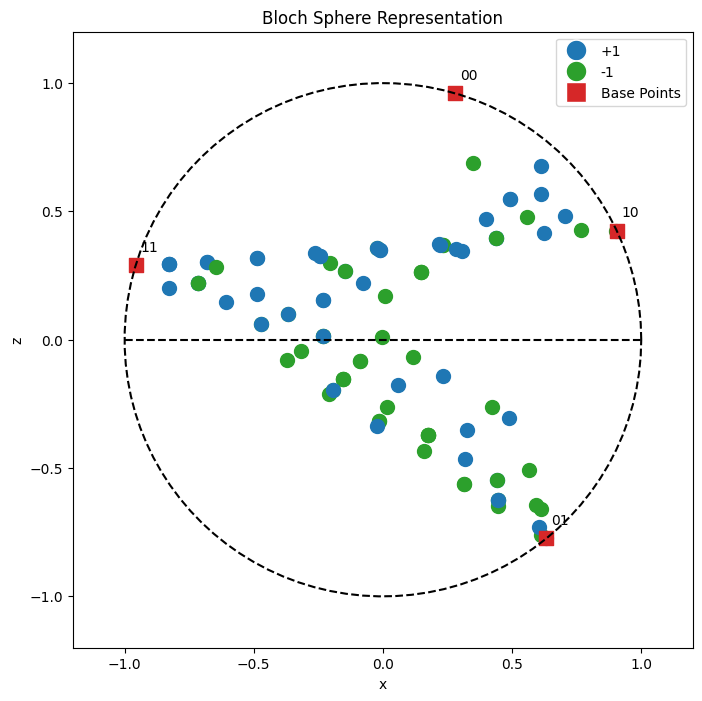

In [4]:
a = np.zeros((len(X), 2))
for i in range(len(X)):
    a[i] = get_bloch_coordinates(x= X[i], theta=theta)
fix_P = [[0, 0], [0, np.pi], [np.pi, 0], [np.pi, np.pi]]
a_base = np.zeros((len(fix_P), 2))
for i in range(len(fix_P)): 
    a_base[i] = get_bloch_coordinates(x= fix_P[i], theta=theta)

plot_bloch_sphere(a,y, a_base)